In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /mount/work 
PATH OF SOURCE:     /mount/work/source 
PATH OF EXECUTABLE: /mount/work/exe 
PATH OF ANNOTATION: /mount/work/annotation 
PATH OF PROJECT:    /mount/project 
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc 


## Helper functions

In [2]:
PREFIX  = "A001_K562_WSTARRseq"

REGIONS = c("GATA1", "MYC")

GROUPS  = c("Input", "Output")

SAMPLES = c(
    paste0("Input_rep",  1:4),
    paste0("Output_rep", 1:3))

CNAMES = c("Chrom", "Start", "End", "Count")

In [3]:
get_info = function(fpath, strings){
    idx = str_detect(string = fpath, pattern = strings)
    return(strings[idx])
}

get_region = function(fpath){return(get_info(fpath, REGIONS))}
get_group  = function(fpath){return(get_info(fpath, GROUPS))}
get_sample = function(fpath){return(get_info(fpath, SAMPLES))}

## library size

In [4]:
fdiry = file.path(FD_RES, "A001_K562_WSTARRseq", "coverage", "library_size")
fname = "library_size_summary.csv"
fpath = file.path(fdiry, fname)

dat_lib = read_csv(fpath) %>% 
    dplyr::mutate(Size = Count) %>% 
    dplyr::select(Sample, Group, Size)
dat_lib

Rows: 7 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Fpath, Sample, Group
dbl (1): Count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sample,Group,Size
<chr>,<chr>,<dbl>
Input_rep1,Input,26908970
Input_rep2,Input,99899775
Input_rep3,Input,105623984
Input_rep4,Input,108635002
Output_rep1,Output,160349140
Output_rep2,Output,157326312
Output_rep3,Output,328185275


## fragment coverage

In [5]:
fdiry = file.path(FD_RES, PREFIX, "coverage_astarrseq_peak_macs_input")
fname = paste0("*bed*")
#dir(fdiry)
fglob = file.path(fdiry, fname)
fpaths = Sys.glob(fglob)
print(fpaths)

 [1] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep1.GATA1.unstranded.bed.gz" 
 [2] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep1.MYC.unstranded.bed.gz"   
 [3] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep2.GATA1.unstranded.bed.gz" 
 [4] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep2.MYC.unstranded.bed.gz"   
 [5] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep3.GATA1.unstranded.bed.gz" 
 [6] "/mount/work/out/proj_combeffect_encode_fcc/A001_K562_WSTARRseq/coverage_astarrseq_peak_macs_input/A001_K562_WSTARRseq_Input_rep3.MYC.unstranded.bed.gz"   
 [7] "/mount/work/out/proj_combeff

In [6]:
lst = lapply(fpaths, function(fpath){
    ###
    reg = get_region(fpath)
    grp = get_group(fpath)
    sam = get_sample(fpath)
    #print(fpath)
    #cat("Region:", reg, ";", "Group:", grp, ";", "Sample:", sam, "\n")
    #flush.console()
    
    ###
    dat = read_tsv(fpath, col_name = CNAMES, show_col_types = FALSE)
    dat = dat %>% 
        dplyr::mutate(Region = reg, Group = grp, Sample = sam) %>%
        dplyr::mutate(across(Count, na_if, ".")) %>%
        dplyr::mutate(across(Count, as.integer)) %>%
        na.omit
    return(dat)
})

dat_cnt = bind_rows(lst)
print(dim(dat_cnt))
head(dat_cnt)

[1] 2694    7


Chrom,Start,End,Count,Region,Group,Sample
<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
chrX,47796208,47796828,11,GATA1,Input,Input_rep1
chrX,47806139,47808167,25,GATA1,Input,Input_rep1
chrX,47809119,47809445,5,GATA1,Input,Input_rep1
chrX,47814810,47815443,15,GATA1,Input,Input_rep1
chrX,47816459,47818070,18,GATA1,Input,Input_rep1
chrX,47836113,47837157,19,GATA1,Input,Input_rep1


In [7]:
### summarize
dat_stats = left_join(dat_cnt, dat_lib, by=c("Sample", "Group")) %>% 
    mutate(Cpm = Count * 10^6 / Size)  %>%
    group_by(Chrom, Start, End, Group, Region) %>%
    summarise(Cpm = mean(Cpm, na.rm=TRUE), .groups = 'drop')

In [8]:
dat_stats

Chrom,Start,End,Group,Region,Cpm
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr8,126778902,126779728,Input,MYC,0.3479838
chr8,126778902,126779728,Output,MYC,0.5005039
chr8,126782925,126783318,Input,MYC,0.1385508
chr8,126782925,126783318,Output,MYC,0.3087751
chr8,126804776,126805825,Input,MYC,0.3672419
chr8,126804776,126805825,Output,MYC,0.8517409
chr8,126817018,126817490,Input,MYC,0.2853607
chr8,126817018,126817490,Output,MYC,0.3209736
chr8,126820465,126821393,Input,MYC,0.5882065


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


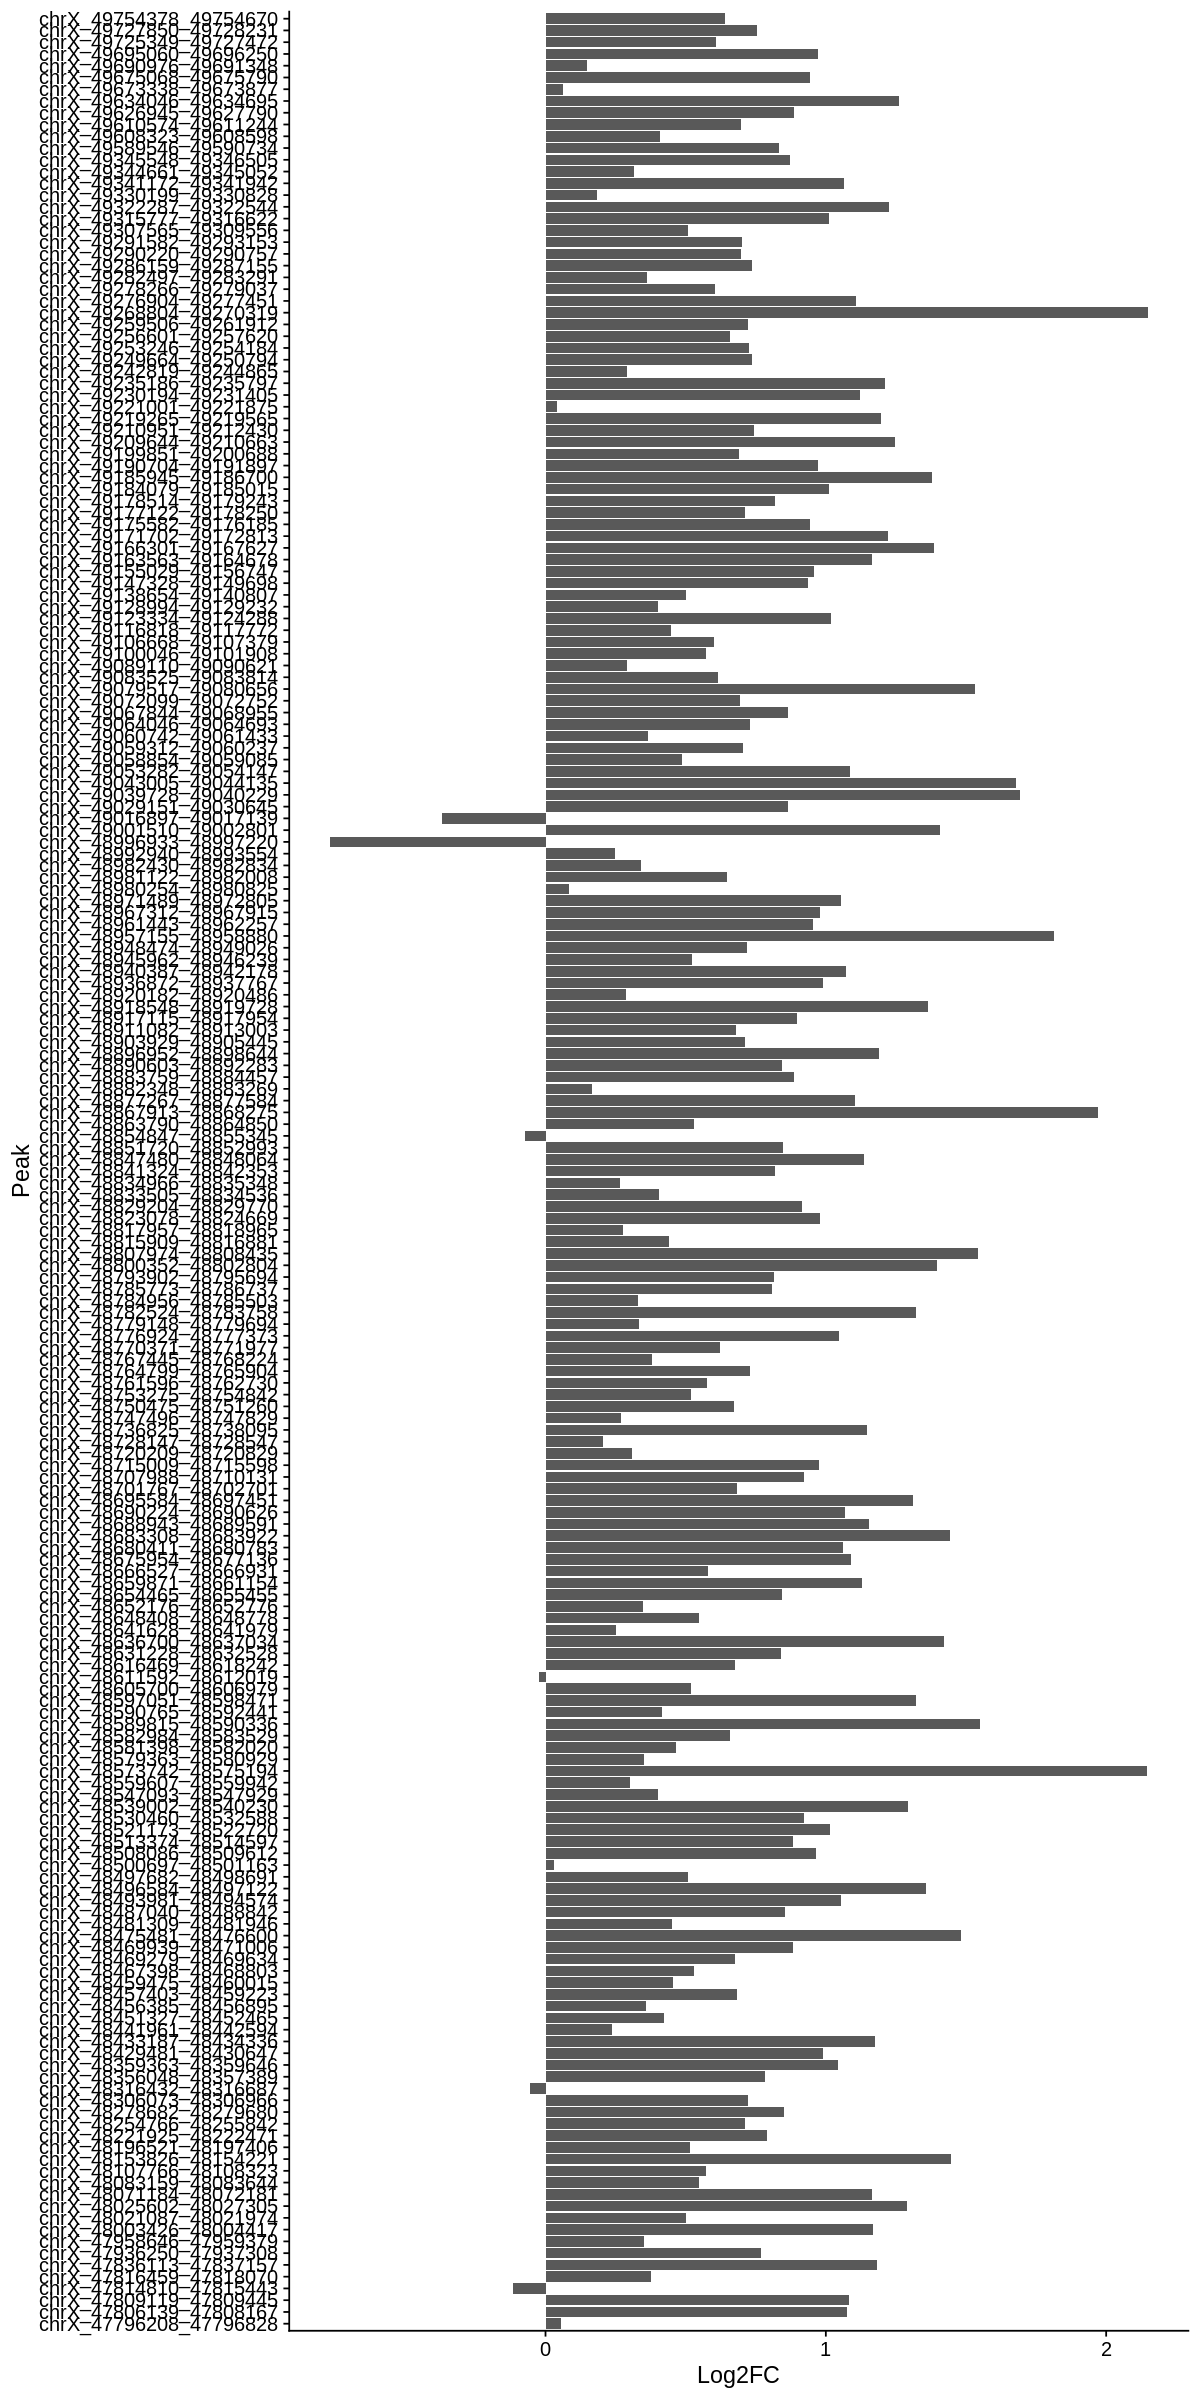

In [9]:
dat = dat_stats
dat = dat %>% 
    dplyr::filter(Region == "GATA1") %>% 
    spread(Group, Cpm) %>% 
    mutate(Log2FC = log2(Output / Input)) %>%
    mutate(Peak=paste(Chrom, Start, End, sep="_"))

gpt = ggplot(dat, aes(x=Log2FC, y=Peak)) + 
    geom_histogram(stat="identity") + 
    theme_cowplot()

options(repr.plot.height=20, repr.plot.width=10)
print(gpt)

In [9]:
PREFIX

[1] "A001_K562_WSTARRseq"

In [10]:
fdiry = file.path(FD_RES, PREFIX, "coverage_astarrseq_peak_macs_input", "summary")
fname = paste0(PREFIX, "_summary.unstranded.tsv")
fpath = file.path(fdiry, fname)
write_tsv(dat_stats, fpath)